In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model

## 2. 

In [2]:
# load data
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# normalize data
train_images = train_images / 255.0
test_images = test_images / 255.0

print (train_images.shape)
print (test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


In [3]:
noise_factor = 0.2
train_images_noisy = train_images + noise_factor * tf.random.normal(shape=train_images.shape) 
test_images_noisy = test_images + noise_factor * tf.random.normal(shape=test_images.shape) 

# Make sure values still in (0,1)
train_imagse_noisy = tf.clip_by_value(train_images_noisy, clip_value_min=0., clip_value_max=1.)
test_images_noisy = tf.clip_by_value(test_images_noisy, clip_value_min=0., clip_value_max=1.)

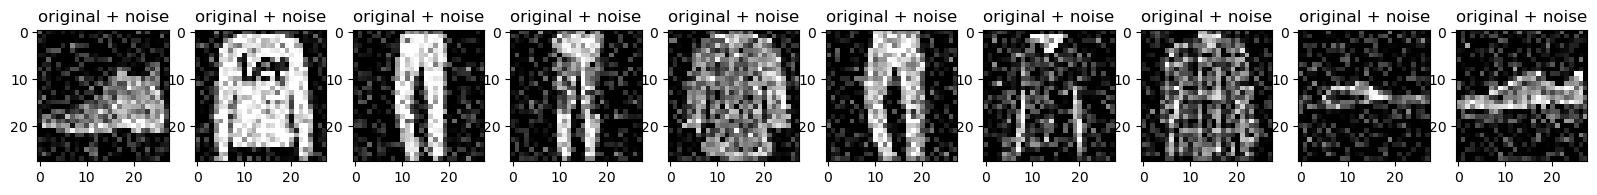

In [4]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(test_images_noisy[i]))
    plt.gray()
plt.show()

## 3.

In [5]:
# declare input shape 
input = tf.keras.Input(shape=(28,28,1))

# Block 1 (convolution)
conv1 = tf.keras.layers.Conv2D(32, 3, strides=1, activation="relu")(input)


# Block 2 (convolution 2)
conv2 = tf.keras.layers.Conv2D(64, 3, strides=1, activation="relu")(conv1)

# Block 3 (full connected9)
fc = tf.keras.layers.Flatten()(conv2)
fc = tf.keras.layers.Dense(10)(fc)

# Finally, we add a classification layer.
output = tf.keras.layers.Dense(10, activation="softmax")(fc)

# bind all
cnn_model = tf.keras.Model(input, output)

In [6]:
# This loss takes care of one-hot encoding (see https://keras.io/api/losses/)
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

cnn_model.compile(loss=loss_fn, optimizer="adam", metrics=["accuracy"])
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 10)                368650    
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
Total params: 387,576
Trainable params: 387,576
Non-trainable

In [7]:
history = cnn_model.fit(train_images, train_labels, epochs=1)

C:\Users\mahad\anaconda3\envs\DATAML200\lib\site-packages\keras\backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1875/1875 [==============================] - 230s 122ms/step - loss: 0.4125 - accuracy: 0.8567


## 4.

In [8]:
test_loss, test_acc = cnn_model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)
accuracies.append(test_acc)

313/313 - 10s - loss: 0.3226 - accuracy: 0.8857 - 10s/epoch - 31ms/step

Test accuracy: 0.885699987411499


## 5.

In [9]:
test_loss, test_acc = cnn_model.evaluate(test_images_noisy,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)
accuracies.append(test_acc)

313/313 - 11s - loss: 0.7656 - accuracy: 0.7229 - 11s/epoch - 35ms/step

Test accuracy: 0.7228999733924866


## 6. 

In [10]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
          tf.keras.layers.Input(shape=(28, 28, 1)),
          tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
          tf.keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
          tf.keras.layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
          tf.keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
          tf.keras.layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])
        
      
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [11]:
autoencoder.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

In [12]:
autoencoder.fit(train_images_noisy, train_images,
                epochs=1,
                shuffle=True,
                validation_data=(test_images_noisy, test_images))

1875/1875 [==============================] - 77s 40ms/step - loss: 0.0173 - val_loss: 0.0102


In [13]:
autoencoder.encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


In [14]:
autoencoder.decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


In [15]:
encoded_imgs = autoencoder.encoder(test_images).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

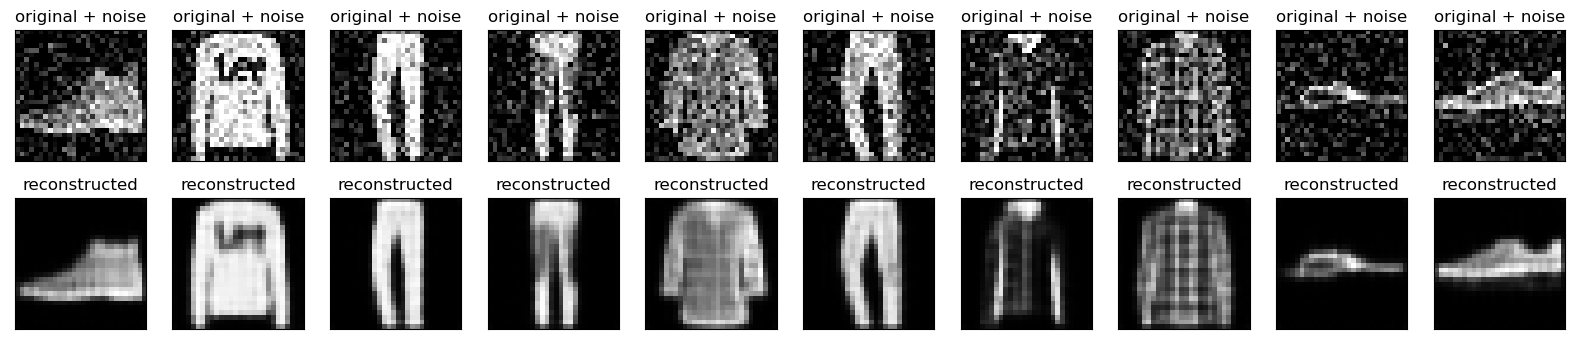

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(test_images_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## 7.

In [17]:
test_loss, test_acc = cnn_model.evaluate(decoded_imgs,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)
accuracies.append(test_acc)

313/313 - 10s - loss: 0.4005 - accuracy: 0.8570 - 10s/epoch - 32ms/step

Test accuracy: 0.8569999933242798


## 8.

In [18]:
history = cnn_model.fit(train_images_noisy, train_labels, epochs=1)

1875/1875 [==============================] - 215s 115ms/step - loss: 0.3541 - accuracy: 0.8708


In [19]:
test_loss, test_acc = cnn_model.evaluate(test_images_noisy,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)
accuracies.append(test_acc)

313/313 - 10s - loss: 0.4055 - accuracy: 0.8554 - 10s/epoch - 31ms/step

Test accuracy: 0.855400025844574


In [ ]:
# ploting accuracies
plt.bar(accuracies_labels, accuracies)
plt.xlabel("Image Types")
plt.ylabel("Accuracy")
plt.title("Accuracy of the model in differnt settings")
plt.show()